In [1]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision import datasets
from collections import Counter

from classic_vit import ViT
from her2_dataset import HER2Dataset
from torchvision.datasets.mnist import MNIST

transform = ToTensor()

torch.manual_seed(0)

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
N_PATCHES = 14


MAX_CHECKPOINTS = 3

assert IMAGE_WIDTH%N_PATCHES==0

PATCH_WIDTH = IMAGE_WIDTH//N_PATCHES
PATCH_HEIGHT = IMAGE_HEIGHT//N_PATCHES


DATASET_PATH='../datasets/HER2_gastric_3classes'
# 20% of data goes to test
TEST_SPLIT = 0.2
BATCH_SIZE = 32

N_EPOCHS = 5
LR = 0.0005


In [2]:
train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

print(f"ROI divided into regions of {IMAGE_WIDTH}x{IMAGE_HEIGHT}x{IMAGE_CHANNELS}\nUsing {N_PATCHES}x{N_PATCHES} patches of {PATCH_WIDTH}x{PATCH_HEIGHT}x{IMAGE_CHANNELS}")
model = ViT(
    in_channels=IMAGE_CHANNELS, 
    patch_size=PATCH_HEIGHT, 
    img_size=28,
    n_classes=10, 
    dropout=0.1, 
    depth=128, 
    num_heads=8,
    emb_size=256
).to(device)
#from vit_pytorch import ViT

# model = ViT(
#     image_size = 28,
#     channels=1,
#     patch_size = 14,
#     num_classes = 10,
#     dim = 1024,
#     depth = 1,
#     heads = 512,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.2f}MB'.format(size_all_mb))


Using device:  cuda (NVIDIA TITAN RTX)
ROI divided into regions of 28x28x1
Using 14x14 patches of 2x2x1
101144330
model size: 385.83MB


In [4]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
    del loss
    del x
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")


Training:   0%|          | 0/5 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 23.64 GiB total capacity; 22.57 GiB already allocated; 21.56 MiB free; 22.87 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


NameError: name 'test_loader' is not defined

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

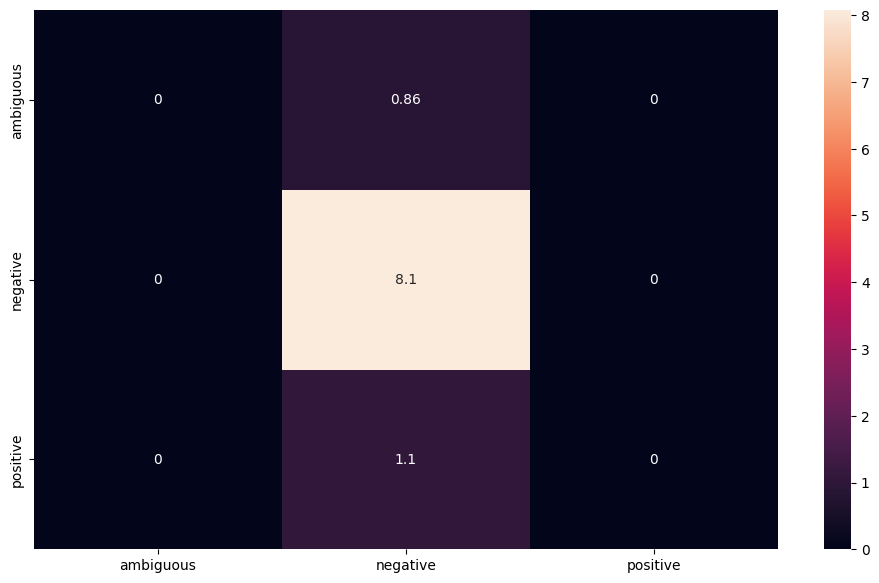

In [ ]:

print(y_pred)
print(y_true)
# constant for classes
classes = dataset.classes
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                    columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

ValueError: max() arg is an empty sequence